Original file by authors: [Minimal Colab](https://colab.research.google.com/github/google-research/scenic/blob/main/scenic/projects/owl_vit/notebooks/OWL_ViT_minimal_example.ipynb)

This file(with some modifications): [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jayhansuh/COLAB-FILES/blob/main/12lbs/OWL-ViT-visualizer.ipynb)

# OWL-ViT minimal example

This Colab shows how to **load a pre-trained OWL-ViT checkpoint** and use it to
**get object detection predictions** for an image.

# Download and install OWL-ViT

OWL-ViT is implemented in [Scenic](https://github.com/google-research/scenic). The cell below installs the Scenic codebase from GitHub and imports it.

In [1]:
!rm -rf *
!rm -rf .config
!rm -rf .git
!git clone https://github.com/google-research/scenic.git .
!python -m pip install -q .
!python -m pip install -r ./scenic/projects/owl_vit/requirements.txt

# Also install big_vision, which is needed for the mask head:
!mkdir /big_vision
!git clone https://github.com/google-research/big_vision.git /big_vision
!python -m pip install -r /big_vision/big_vision/requirements.txt
import sys
sys.path.append('/big_vision/')
!echo "Done."

Cloning into '.'...
remote: Enumerating objects: 5568, done.
remote: Counting objects: 100% (332/332), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 5568 (delta 160), reused 273 (delta 131), pack-reused 5236
Receiving objects: 100% (5568/5568), 51.02 MiB | 11.03 MiB/s, done.
Resolving deltas: 100% (3751/3751), done.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 2.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5pxl3vg4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5pxl3vg4


In [2]:
import os

import jax
from matplotlib import pyplot as plt
import numpy as np
from scenic.projects.owl_vit import models
from scenic.projects.owl_vit.configs import clip_b32
from scipy.special import expit as sigmoid
import skimage
from skimage import io as skimage_io
from skimage import transform as skimage_transform

# Choose config

In [3]:
config = clip_b32.get_config(init_mode='canonical_checkpoint')

# Load the model and variables

In [4]:
module = models.TextZeroShotDetectionModule(
    body_configs=config.model.body,
    normalize=config.model.normalize,
    box_bias=config.model.box_bias)

In [5]:
variables = module.load_variables(config.init_from.checkpoint_path)

# Prepare image

In [6]:
# Load example image:
filename = os.path.join(skimage.data_dir, 'astronaut.png')
image_uint8 = skimage_io.imread(filename)
image = image_uint8.astype(np.float32) / 255.0

# Pad to square with gray pixels on bottom and right:
h, w, _ = image.shape
size = max(h, w)
image_padded = np.pad(
    image, ((0, size - h), (0, size - w), (0, 0)), constant_values=0.5)

# Resize to model input size:
input_image = skimage.transform.resize(
    image_padded,
    (config.dataset_configs.input_size, config.dataset_configs.input_size),
    anti_aliasing=True)

# Prepare text queries

In [7]:
text_queries = ['human face', 'rocket', 'nasa badge', 'star-spangled banner']
tokenized_queries = np.array([
    module.tokenize(q, config.dataset_configs.max_query_length)
    for q in text_queries
])

# Pad tokenized queries to avoid recompilation if number of queries changes:
tokenized_queries = np.pad(
    tokenized_queries,
    pad_width=((0, 100 - len(text_queries)), (0, 0)),
    constant_values=0)

100%|█████████████████████████████████████| 1.29M/1.29M [00:00<00:00, 25.9MiB/s]


# Get predictions
This will take a minute on the first execution due to model compilation. Subsequent executions will be faster.

In [8]:
jitted = jax.jit(module.apply, static_argnames=('train',))

In [9]:
# Note: The model expects a batch dimension.
predictions = jitted(
    variables,
    input_image[None, ...],
    tokenized_queries[None, ...],
    train=False)

# Remove batch dimension and convert to numpy:
predictions = jax.tree_util.tree_map(lambda x: np.array(x[0]), predictions )

# Plot predictions

In [10]:
%matplotlib inline

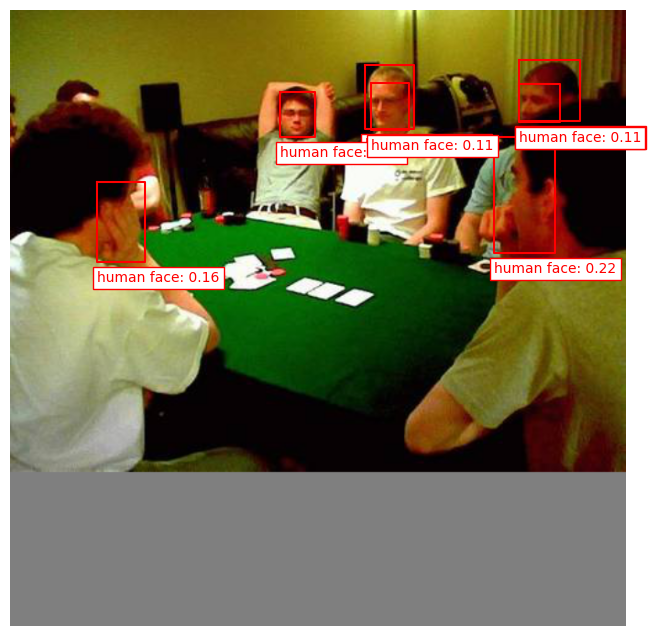

In [223]:
score_threshold = 0.1

logits = predictions['pred_logits'][..., :len(text_queries)]  # Remove padding.
scores = sigmoid(np.max(logits, axis=-1))
labels = np.argmax(predictions['pred_logits'], axis=-1)
boxes = predictions['pred_boxes']

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(input_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for score, box, label in zip(scores, boxes, labels):
  if score < score_threshold:
    continue
  cx, cy, w, h = box
  ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
          [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2], 'r')
  ax.text(
      cx - w / 2,
      cy + h / 2 + 0.015,
      f'{text_queries[label]}: {score:1.2f}',
      ha='left',
      va='top',
      color='red',
      bbox={
          'facecolor': 'white',
          'edgecolor': 'red',
          'boxstyle': 'square,pad=.3'
      })

# Models with segmentation mask head

## Load model with mask head

In [12]:
from scenic.projects.owl_vit.configs import clip_l14_with_masks

In [13]:
config = clip_l14_with_masks.get_config(init_mode='canonical_checkpoint')

In [14]:
module = models.TextZeroShotDetectionModule(
    body_configs=config.model.body,
    mask_head_configs=config.model.mask_head,
    normalize=config.model.normalize,
    box_bias=config.model.box_bias)

In [15]:
variables = module.load_variables(config.init_from.checkpoint_path)

In [16]:
jitted = jax.jit(module.apply, static_argnames=('train',))

In [17]:
# Resize to model input size:
input_image = skimage.transform.resize(
    image_padded,
    (config.dataset_configs.input_size, config.dataset_configs.input_size),
    anti_aliasing=True)

# Note: The model expects a batch dimension.
predictions = jitted(
    variables,
    input_image[None, ...],
    tokenized_queries[None, ...],
    train=False)

# Remove batch dimension and convert to numpy:
predictions = jax.tree_util.tree_map(lambda x: np.array(x[0]), predictions )

## Plot predictions, including masks

In [18]:
%matplotlib inline

(1.0, 0.0)

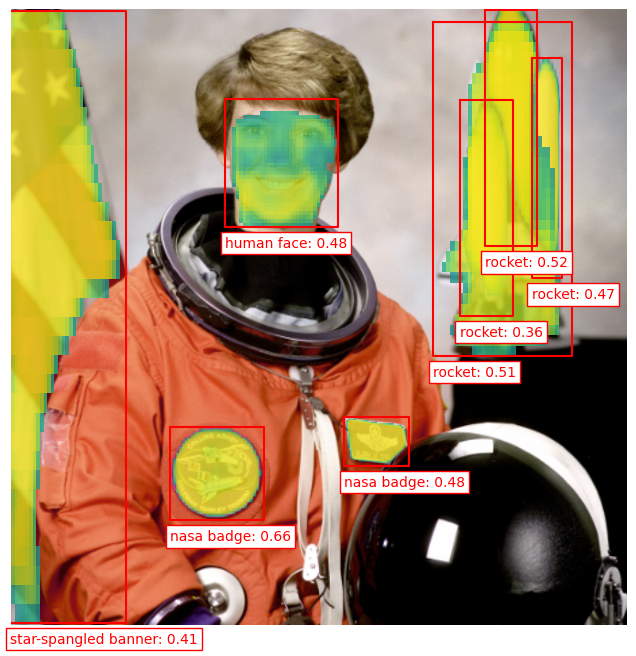

In [19]:
score_threshold = 0.3

logits = predictions['pred_logits'][..., :len(text_queries)]  # Remove padding.
scores = sigmoid(np.max(logits, axis=-1))
labels = np.argmax(predictions['pred_logits'], axis=-1)
boxes = predictions['pred_boxes']

masks = [None] * len(boxes)
if 'pred_masks' in predictions:
  masks = sigmoid(predictions['pred_masks'])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(input_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for score, box, label, mask in zip(scores, boxes, labels, masks):
  if score < score_threshold:
    continue
  cx, cy, w, h = box
  ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
          [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2], 'r')
  
  if mask is not None:
    mask_img = plt.cm.viridis(mask)
    mask_img[..., -1] = (mask > 0.5) * 0.8
    extent = np.array((cx - w / 2, cx + w / 2, cy + h / 2, cy - h / 2))
    ax.imshow(mask_img, extent=np.clip(extent, 0, 1))
  
  ax.text(
      cx - w / 2,
      cy + h / 2 + 0.015,
      f'{text_queries[label]}: {score:1.2f}',
      ha='left',
      va='top',
      color='red',
      bbox={
          'facecolor': 'white',
          'edgecolor': 'red',
          'boxstyle': 'square,pad=.3'
      })

ax.set_xlim(0, 1)
ax.set_ylim(1, 0)

# Customized visulization

In [240]:
import json

In [272]:
# This file 
queryfile = json.load(open('flickr-examples.json'))
imgnames = list(queryfile.keys())
num_samples = len(imgnames)

In [273]:
print(queryfile)

{'7173663269.jpg': [['two older folks'], [152, 100, 273, 228]], '226115048.jpg': [['a beer'], [112, 220, 152, 299]], '3782318456.jpg': [['equipment'], [3, 122, 491, 500]], '3517370470.jpg': [['one'], [152, 113, 267, 428]], '3329777647.jpg': [['a ball'], [363, 217, 401, 245]], '543603259.jpg': [['a wall'], [203, 130, 339, 425]], '4776990069.jpg': [['a carousel'], [146, 167, 394, 375]], '4756254503.jpg': [['two ice cream cones'], [147, 138, 206, 182]], '217108448.jpg': [['a telescope'], [113, 109, 287, 478]], '2534137886.jpg': [['a heavy bucket'], [188, 201, 364, 311]], '2620517927.jpg': [['motorcycles'], [46, 238, 288, 307]], '1045521051.jpg': [['the TV'], [44, 11, 171, 153]], '186487635.jpg': [['a wall'], [248, 11, 352, 475]], '3407528957.jpg': [['a table'], [155, 243, 472, 334]], '7573421864.jpg': [['leopard print paper'], [64, 18, 278, 487]], '3393035454.jpg': [['a tan rock'], [268, 291, 355, 383]]}


In [274]:
imgs = []
texts = []
bbox_gts = []
predictions_list = []

In [275]:
for imname in imgnames:
    image_uint8 = skimage.io.imread('flickr-examples/'+imname)
    image = image_uint8.astype(np.float32) / 255.0

    # Pad image to square:
    h, w, _ = image.shape
    size = max(h, w)
    image_padded = np.pad(
        image, ((0, size - h), (0, size - w), (0, 0)), constant_values=0.5)

    # Resize to model input size:
    input_image = skimage.transform.resize(
        image_padded,
        (config.dataset_configs.input_size, config.dataset_configs.input_size),
        anti_aliasing=True)
    
    text_queries = queryfile[imname][0]
    tokenized_queries = np.array([
        module.tokenize(q, config.dataset_configs.max_query_length)
        for q in text_queries
    ])

    # Pad tokenized queries to avoid recompilation if number of queries changes:
    tokenized_queries = np.pad(
        tokenized_queries,
        pad_width=((0, 100 - len(text_queries)), (0, 0)),
        constant_values=0)

    # Note: The model expects a batch dimension.
    predictions = jitted(
        variables,
        input_image[None, ...],
        tokenized_queries[None, ...],
        train=False)
    
    # Remove batch dimension and convert to numpy:
    predictions = jax.tree_util.tree_map(lambda x: np.array(x[0]), predictions )

    # Append to the list
    predictions_list.append(predictions)
    imgs.append(input_image)
    texts.append(text_queries[0])
    bbox_gts.append(queryfile[imname][1])

In [278]:
######## Visualize multiple images in Grid ########

# Set the number of rows and columns in the grid
row_num = num_samples // 4 + (1 if num_samples % 4 != 0 else 0)
row_num = max(row_num, 2) # at least 2 rows
col_num = 4

# Red: predicted bounding box
# Blue: ground truth bounding box
fig, axs = plt.subplots(row_num, col_num, figsize=(20, 20))

for i in range(row_num):
    for j in range(col_num):
        idx = i*col_num + j
        axs[i,j].set_axis_off()
        if(idx<len(predictions_list)):
          predictions = predictions_list[idx]

          logits = predictions['pred_logits'][..., :len(text_queries)]  # Remove padding.
          scores = sigmoid(np.max(logits, axis=-1))
          labels = np.argmax(predictions['pred_logits'], axis=-1)
          boxes = predictions['pred_boxes']
          
          ax = axs[i,j]

          im = imgs[idx]

          ######### Visualize ground truth bounding box #########
          ######### Could not fix the bug by the different coordinate system #########
          # bbox_gt = bbox_gts[idx]
          # im = cv2.rectangle(im, (int(bbox_gt[0]), int(bbox_gt[1])), (int(bbox_gt[2]), int(bbox_gt[3])), (50/255, 50/255, 255/255), 2)

          ax.imshow(im, extent=(0, 1, 1, 0))
          ax.set_axis_off()
          ax.set_title(texts[idx])

          sortbyscore = list(zip(scores, boxes, labels))
          sortbyscore.sort(key=lambda x: x[0],reverse=True)
          
          for score, box, label in sortbyscore[:1]:
            cx, cy, w, h = box
            ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
                    [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2], 'r')

plt.show()

Output hidden; open in https://colab.research.google.com to view.